# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
import os
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)
import keras

Using TensorFlow backend.


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 20 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [4]:
compressed_image_x = 40
compressed_image_y = 40
image_index = np.arange(1,30,2) # Take alternative images
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    # Number of Images need to consider 
    img_idx = image_index #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = (len(folder_list))//batch_size# calculate the number of batches
        pending_Data = (len(folder_list)) - (num_batches * batch_size)
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),compressed_image_x,compressed_image_y,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #image = imread(source_path+'/'+ t[folder].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = imresize(image,(compressed_image_x,compressed_image_y,3)) # As 1 Image size is 360*360 and another is 120*160. Hence both converted to 100*100
                    image_0 = image[:,:, 0]/255
                    image_1 = image[:,:, 1]/255
                    image_2 = image[:,:, 2]/255
                    batch_data[folder,idx,:,:,0] = image_0 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image_1 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image_2 #normalise and feed in the image
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        # write the code for the remaining data points which are left after full batches
        if(pending_Data > 0):
            batch_data = np.zeros((batch_size,len(img_idx),compressed_image_x,compressed_image_y,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5))
            for folder in range(pending_Data):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches * batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (num_batches * batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    image = imresize(image,(compressed_image_x,compressed_image_y,3)) # As 1 Image size is 360*360 and another is 120*160. Hence both converted to 100*100
                    image_0 = image[:,:, 0]/255
                    image_1 = image[:,:, 1]/255
                    image_2 = image[:,:, 2]/255
                    batch_data[folder,idx,:,:,0] = image_0 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = image_1 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = image_2 #normalise and feed in the image
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [5]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


In [6]:
num_classes = 5
#Shape to the Conv3D is initialized here
input_shape = np.zeros((batch_size,len(image_index),compressed_image_x,compressed_image_y,3))

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## Conv3D

In [7]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.regularizers import l2

def conv3D(useMoresLayer = False):
    # #write your model here
    model = Sequential()
    model.add(Conv3D(64, (3, 3, 3), padding='same', 
                    input_shape=input_shape.shape[1:]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv3D(64, (3, 3, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(3, 3, 3)))
    model.add(Dropout(0.30))
    
    if useMoresLayer:
        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Conv3D(64, (2, 2, 2)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(0.25))
        
        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Conv3D(128, (2, 2, 2)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    
    return model

## Conv2D + LSTM

In [8]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
from keras.layers.convolutional import Conv3D, Conv2D, MaxPooling3D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.regularizers import l2

def conv2d_With_LSTM(useMoresLayer = False):
    #write your model here
    model = Sequential()

    model.add(TimeDistributed(Conv2D(32, (3, 3), strides=(2, 2),
                activation='relu', padding='same'), input_shape=input_shape.shape[1:]))
    model.add(TimeDistributed(Conv2D(32, (3,3),
                kernel_initializer="he_normal", activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
    model.add(TimeDistributed(Dropout(0.20)))

    model.add(TimeDistributed(Conv2D(64, (3,3),
                padding='same', activation='relu')))
    model.add(TimeDistributed(Conv2D(64, (3,3),
                padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
    model.add(TimeDistributed(Dropout(0.20)))
    if useMoresLayer:
        model.add(TimeDistributed(Conv2D(128, (3,3),
                    padding='same', activation='relu')))
        model.add(TimeDistributed(Conv2D(128, (3,3),
                    padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
        model.add(TimeDistributed(Dropout(0.25)))

        model.add(TimeDistributed(Conv2D(256, (3,3),
                    padding='same', activation='relu')))
        model.add(TimeDistributed(Conv2D(256, (3,3),
                    padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
        model.add(TimeDistributed(Dropout(0.25)))

        model.add(TimeDistributed(Conv2D(512, (3,3),
                    padding='same', activation='relu')))
        model.add(TimeDistributed(Conv2D(512, (3,3),
                    padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
        model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))

    #model.add(Dropout(0.5))
    model.add(LSTM(256, return_sequences=False, dropout=0.20))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model


## Conv2D + GRU

In [9]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM
from keras.layers.convolutional import Conv3D, Conv2D, MaxPooling3D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.regularizers import l2

def Conv2d_With_GRU(useMoresLayer = False):
    #write your model here
    model = Sequential()

    model.add(TimeDistributed(Conv2D(32, (3, 3), strides=(2, 2),
                activation='relu', padding='same'), input_shape=input_shape.shape[1:]))
    model.add(TimeDistributed(Conv2D(32, (3,3),
                kernel_initializer="he_normal", activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
    model.add(TimeDistributed(Dropout(0.20)))

    model.add(TimeDistributed(Conv2D(64, (3,3),
                padding='same', activation='relu')))
    model.add(TimeDistributed(Conv2D(64, (3,3),
                padding='same', activation='relu')))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
    model.add(TimeDistributed(Dropout(0.20)))
    if useMoresLayer:
        model.add(TimeDistributed(Conv2D(128, (3,3),
                    padding='same', activation='relu')))
        model.add(TimeDistributed(Conv2D(128, (3,3),
                    padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
        model.add(TimeDistributed(Dropout(0.25)))

        model.add(TimeDistributed(Conv2D(256, (3,3),
                    padding='same', activation='relu')))
        model.add(TimeDistributed(Conv2D(256, (3,3),
                    padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
        model.add(TimeDistributed(Dropout(0.25)))

        model.add(TimeDistributed(Conv2D(512, (3,3),
                    padding='same', activation='relu')))
        model.add(TimeDistributed(Conv2D(512, (3,3),
                    padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))
        model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))

    #model.add(Dropout(0.5))
    model.add(GRU(256, return_sequences=False, dropout=0.20))
    model.add(Dense(num_classes, activation='softmax'))
    return model


## Transfer Learning + LSTM/GRU (ResNet)

In [10]:
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, Input,Multiply, Masking, Reshape, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM, GlobalAveragePooling2D
from keras.layers.convolutional import Conv3D, Conv2D, MaxPooling3D, MaxPooling2D 
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.regularizers import l2
def Resnet_CNN_LSTM():
    resnet = ResNet50(include_top=False, weights='imagenet', pooling = 'avg')
    input_layer = Input(shape=input_shape.shape[1:])
    curr_layer = TimeDistributed(resnet)(input_layer)
    #curr_layer = Dropout(0.25)(curr_layer)
    curr_layer = Reshape(target_shape=(input_shape.shape[1:][0], 2048))(curr_layer)
    lstm_out = LSTM(256, dropout=0.25)(curr_layer)
    output = Dense(output_dim=num_classes, activation='softmax')(lstm_out)
    model = Model([input_layer], output)
    return model

def Resnet_CNN_GRU():
    resnet = ResNet50(include_top=False, weights='imagenet', pooling = 'avg')
    input_layer = Input(shape=input_shape.shape[1:])
    curr_layer = TimeDistributed(resnet)(input_layer)
    #curr_layer = Dropout(0.25)(curr_layer)
    curr_layer = Reshape(target_shape=(input_shape.shape[1:][0], 2048))(curr_layer)
    gru_out = GRU(256, dropout=0.25)(curr_layer)
    output = Dense(output_dim=num_classes, activation='softmax')(gru_out)
    model = Model([input_layer], output)
    return model

## Transfer Learning + LSTM (VggNet)

In [11]:
from keras.applications import vgg16
def Vgg_CNN_LSTM():
    vggNet = vgg16.VGG16(weights='imagenet', include_top=False, pooling='avg')
    input_layer = Input(shape=input_shape.shape[1:])
    curr_layer = TimeDistributed(vggNet)(input_layer)
    #curr_layer = Dropout(0.25)(curr_layer)
    curr_layer = Reshape(target_shape=(input_shape.shape[1:][0], 512))(curr_layer)
    gru_out = LSTM(256, dropout=0.25)(curr_layer)
    output = Dense(output_dim=num_classes, activation='softmax')(gru_out)
    model = Model([input_layer], output)
    return model

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

## Master Function to Select Model

In [12]:
"""
    modelName:
                1. Resnet_CNN_LSTM
                2. Resnet_CNN_GRU
                3. Conv2d_With_GRU
                4. conv2d_With_LSTM
                5. conv3D
                6. Vgg_CNN_LSTM
"""

def modelExecution(modelName = 'Resnet_CNN_LSTM'):
    if modelName == 'Resnet_CNN_LSTM':
        model = Resnet_CNN_LSTM()
    elif modelName == 'Resnet_CNN_GRU':
        model = Resnet_CNN_GRU()
    elif modelName == 'Cov2d_With_GRU':
        model = Cov2d_With_GRU()
    elif modelName == 'conv2d_With_LSTM':
        model = conv2d_With_LSTM()
    elif modelName == 'Vgg_CNN_LSTM':
        model = Vgg_CNN_LSTM()
    else:
        model = conv3D()
    return model, modelName

## Final Model Selection and Execution

In [13]:
model, modelName = modelExecution(modelName = 'Resnet_CNN_LSTM')

C:\Users\hruda\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=5, activation="softmax")`
  app.launch_new_instance()


In [14]:
optimiser = 'SGD'#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 15, 40, 40, 3)     0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 15, 2048)          23587712  
_________________________________________________________________
reshape_1 (Reshape)          (None, 15, 2048)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               2360320   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 25,949,317
Trainable params: 25,896,197
Non-trainable params: 53,120
_________________________________________________________________
None


Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [15]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [16]:
class DecayLR(keras.callbacks.Callback):
    def __init__(self, base_lr=0.1, decay_epoch=1):
        super(DecayLR, self).__init__()
        self.base_lr = base_lr
        self.decay_epoch = decay_epoch 
        self.lr_history = []
        
    def on_train_begin(self, logs={}):
        K.set_value(self.model.optimizer.lr, self.base_lr)

    def on_epoch_end(self, epoch, logs={}):
        new_lr = self.base_lr * (0.5 ** (epoch // self.decay_epoch))
        self.lr_history.append(K.get_value(self.model.optimizer.lr))
        K.set_value(self.model.optimizer.lr, new_lr)

In [17]:
model_name = modelName + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = DecayLR() # write the REducelronplateau code here
#auc_logger = roc_callback()
#callbacks_list = [checkpoint, LR, auc_logger]
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [18]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [19]:
modelExec_History = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/10
Source path =  Project_data/val ; batch size = 20
Source path =  Project_data/train ; batch size = 20
34/34 [==============================] - 161s 5s/step - loss: 1.1920 - categorical_accuracy: 0.5235 - val_loss: 2.3100 - val_categorical_accuracy: 0.3400

Epoch 00001: saving model to Resnet_CNN_LSTM_2019-03-1607_51_10.774855/model-00001-1.19202-0.52353-2.31004-0.34000.h5
Epoch 2/10
34/34 [==============================] - 218s 6s/step - loss: 0.5959 - categorical_accuracy: 0.7603 - val_loss: 1.8790 - val_categorical_accuracy: 0.4800

Epoch 00002: saving model to Resnet_CNN_LSTM_2019-03-1607_51_10.774855/model-00002-0.59585-0.76029-1.87898-0.48000.h5
Epoch 3/10
34/34 [==============================] - 218s 6s/step - loss: 0.2505 - categorical_accuracy: 0.9015 - val_loss: 1.1392 - val_categorical_accuracy: 0.6200

Epoch 00003: saving model to Resnet_CNN_LSTM_2019-03-1607_51_10.774855/model-00003-0.25045-0.90147-1.13923-0.62000.h5
Epoch 4/10
34/34 [============================

dict_keys(['categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'loss'])


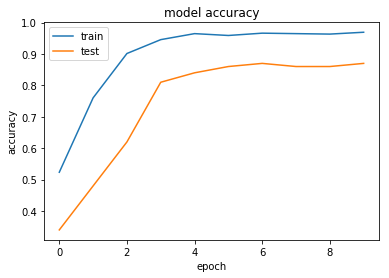

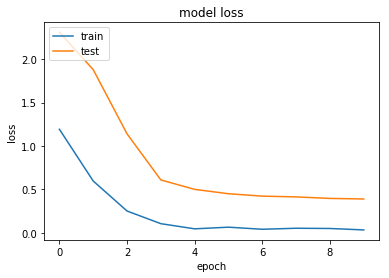

In [21]:
# list all data in history
import matplotlib.pyplot as plt
print(modelExec_History.history.keys())
# summarize history for accuracy
plt.plot(modelExec_History.history['categorical_accuracy'])
plt.plot(modelExec_History.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(modelExec_History.history['loss'])
plt.plot(modelExec_History.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()